<a href="https://colab.research.google.com/github/AMAZINGMAN2/COOLWEBSITE/blob/main/stockPredictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [184]:
#!pip install alpaca-trade-api tensorflow pandas numpy
#!pip install --upgrade tensorflow
import alpaca_trade_api as tradeapi
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from google.colab import drive
import joblib
#drive.mount('/content/drive')
# Set your Alpaca API key and secret
api_key = 'PKP989B38C7UZH2A4SF6'
api_secret = 'kJXBy4F0K0xq7SU6xSXGfhrw7QSNCS5rVBRfnRpj'

# Set Alpaca API base URL for trading
base_url = 'https://api.alpaca.markets'

api = tradeapi.REST(api_key, api_secret, base_url=base_url)

def get_alpaca_data(api, symbol, start_date, end_date, timeframe, limit):
    data = api.get_bars(symbol, timeframe, limit=limit, start=start_date, end=end_date).df
    return data

symbol = 'ETH'  # example
start_date = '2020-04-01'
end_date = '2023-12-31'
timeframe = '1Hour'  # change this to 1Min, 3Min, 5Min, 15Min, 1Hour, 4Hour, 1Day etc..
limit = 100000000000

historical_data = get_alpaca_data(api, symbol, start_date, end_date, timeframe, limit)

print(historical_data.head())

close_prices = historical_data['close']

print(close_prices)

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(historical_data[['close']].values)

scaler_path = '/content/drive/MyDrive/StockPrediction/scaler1.pkl'
joblib.dump(scaler, scaler_path)

sequence_length = 25
sequences = []
next_price = []

for i in range(len(scaled_data) - sequence_length):
    sequences.append(scaled_data[i:i+sequence_length])
    next_price.append(scaled_data[i+sequence_length])
X = np.array(sequences)
y = np.array(next_price)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

predictions = model.predict(X_test)

model.save('/content/drive/MyDrive/StockPrediction/stockPredictionLSTMModel1.keras')


                            close   high      low  trade_count    open  \
timestamp                                                                
2020-04-01 13:00:00+00:00   9.730   9.90   9.7065          187   9.790   
2020-04-01 14:00:00+00:00  10.225  10.30   9.6800          787   9.805   
2020-04-01 15:00:00+00:00  10.360  10.56  10.0000          802  10.200   
2020-04-01 16:00:00+00:00   9.880  10.35   9.8400          558  10.350   
2020-04-01 17:00:00+00:00   9.800   9.96   9.6500          379   9.880   

                           volume       vwap  
timestamp                                     
2020-04-01 13:00:00+00:00   17305   9.811058  
2020-04-01 14:00:00+00:00   69754   9.945846  
2020-04-01 15:00:00+00:00   56243  10.253977  
2020-04-01 16:00:00+00:00   39907  10.017047  
2020-04-01 17:00:00+00:00   25302   9.783146  
timestamp
2020-04-01 13:00:00+00:00     9.730
2020-04-01 14:00:00+00:00    10.225
2020-04-01 15:00:00+00:00    10.360
2020-04-01 16:00:00+00:00     9.88

2/2 [==============================] - 1s 13ms/step


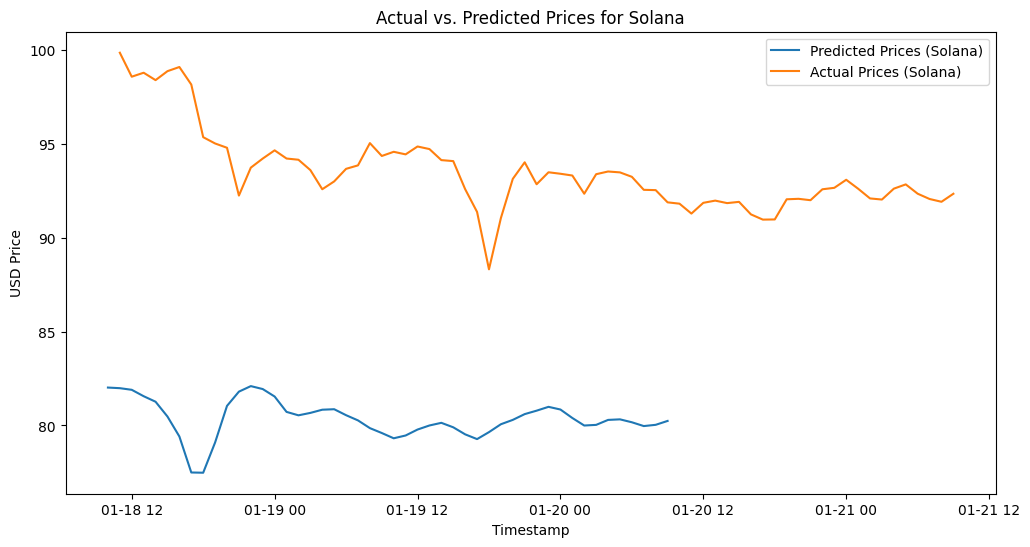

Mean Absolute Error for Solana: 12.137883934110462


In [168]:
# Install necessary libraries
#!pip install requests pandas matplotlib tensorflow

import requests
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from datetime import datetime
import numpy as np
from tensorflow.keras.models import load_model
import joblib

# Function to preprocess data for LSTM
def preprocess_data_for_lstm(data, scaler, sequence_length):
    scaled_data = scaler.transform(data[['close']].values)

    sequences = []
    next_price = []

    for i in range(len(scaled_data) - sequence_length):
        sequences.append(scaled_data[i:i+sequence_length])
        next_price.append(scaled_data[i+sequence_length])

    X = np.array(sequences)
    y = np.array(next_price)

    return X, y

# Load pre-trained LSTM model and scaler
model_path = '/content/drive/MyDrive/StockPrediction/stockPredictionLSTMModel.keras'  # Update with the actual path to your saved model
scaler_path = '/content/drive/MyDrive/StockPrediction/scaler.pkl'  # Update with the actual path to your saved scaler

model = load_model(model_path)
scaler = joblib.load(scaler_path)  # Load the MinMaxScaler from scikit-learn

# Fetch historical data for Solana from CoinGecko API
symbol_solana = 'solana'
vs_currency = 'usd'
start_date = '2024-01-17'
end_date = '2024-01-20'
interval = '1h'

url = f'https://api.coingecko.com/api/v3/coins/solana/market_chart'
params = {
    'vs_currency': vs_currency,
    'from': int(datetime.strptime(start_date, "%Y-%m-%d").timestamp()),
    'to': int(datetime.strptime(end_date, "%Y-%m-%d").timestamp()),
    'days': (datetime.strptime(end_date, "%Y-%m-%d") - datetime.strptime(start_date, "%Y-%m-%d")).days,
}

response = requests.get(url, params=params)
data = response.json()

# Extract data
prices_data = data.get('prices', [])
if not prices_data:
    raise ValueError("Unexpected data structure. Check the response from the CoinGecko API.")


historical_data_solana = pd.DataFrame(prices_data, columns=['timestamp', 'close'])
historical_data_solana['timestamp'] = pd.to_datetime(historical_data_solana['timestamp'], unit='ms')

# Resample the data to the desired interval (e.g., 1 hour)
historical_data_solana.set_index('timestamp', inplace=True)
historical_data_solana_resampled = historical_data_solana.resample('1H').ffill().reset_index()

# Preprocess data for LSTM
sequence_length = 25
X_solana, y_solana = preprocess_data_for_lstm(historical_data_solana, scaler, sequence_length)

# Make predictions using the LSTM model
predictions_solana = model.predict(X_solana)

# Invert scaling to get the original prices
predicted_prices_solana = scaler.inverse_transform(np.concatenate([X_solana[:, -1], predictions_solana], axis=1))[:, 1]

# Plot Actual vs. Predicted Prices
plt.figure(figsize=(12, 6))
num_predictions = len(predicted_prices_solana)
timestamp_subset = historical_data_solana_resampled['timestamp'].head(num_predictions).to_numpy()
plt.plot(timestamp_subset, predicted_prices_solana, label='Predicted Prices (Solana)')
plt.plot(historical_data_solana_resampled['timestamp'], historical_data_solana_resampled['close'], label='Actual Prices (Solana)')
plt.title('Actual vs. Predicted Prices for Solana')
plt.xlabel('Timestamp')
plt.ylabel('USD Price')
plt.legend()
plt.show()



# Calculate mean absolute error
mae_solana = mean_absolute_error(historical_data_solana['close'][sequence_length:], predicted_prices_solana)
print(f'Mean Absolute Error for Solana: {mae_solana}')


In [85]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')


Mean Squared Error: 0.0026940963465694897
Mean Absolute Error: 0.037750952794525276


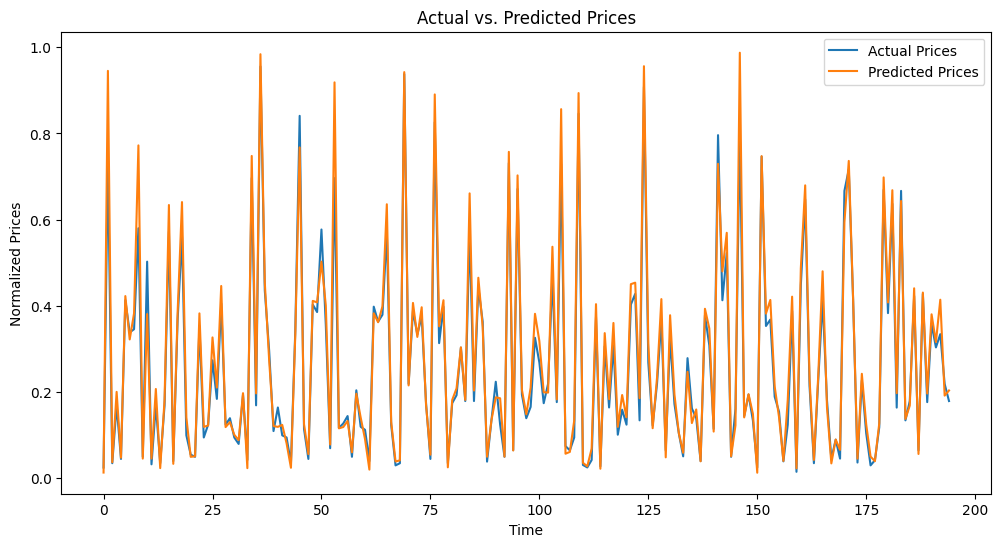

In [122]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual Prices')
plt.plot(predictions, label='Predicted Prices')
plt.title('Actual vs. Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Normalized Prices')
plt.legend()
plt.show()